In [2]:
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt
from torchcubicspline import(natural_cubic_spline_coeffs, 
                             NaturalCubicSpline)

from stein_mpc.inference import SVGD
from stein_mpc.kernels import GaussianKernel, TrajectoryKernel, PathSigKernel


In [3]:
# 2D plotting function
def plot_2d(log_p, x_lim=(0.0, 3.5), y_lim=(-2.0, 2.5), grid_size=100):
    ngrid = 100
    x = torch.linspace(*x_lim, grid_size)
    y = torch.linspace(*y_lim, grid_size)
    X, Y = torch.meshgrid(x,y)
    Z = torch.exp(log_p(torch.stack((X.flatten(), Y.flatten()), dim=0).T)).reshape(grid_size, grid_size)

    plt.figure(figsize = (10, 10))
    plt.contourf(X, Y, Z.data.numpy(), 30)
    plt.xlim(x_lim)
    plt.ylim(y_lim) 

def create_spline_trajectory(knots, timesteps=100):
    t = torch.linspace(0, 1, timesteps)
    t_knots = torch.linspace(0, 1, knots.shape[-2])
    coeffs = natural_cubic_spline_coeffs(t_knots, knots)
    spline = NaturalCubicSpline(coeffs)
    return spline.evaluate(t)

In [50]:
# Defines cost functions and sets up the problem

# Two Gaussians
w = torch.tensor([0.5, 0.5])
mean = torch.tensor([[1., 1.], [2, 1.25]])
var  = torch.tensor([[.25, .25], [.25, .25]])
mix = dist.Categorical(w)
comp = dist.Independent(dist.Normal(mean, var), 1)
log_p = dist.MixtureSameFamily(mix, comp).log_prob

# Defines the cost function as a function of x which is a 3 x 2 differentiable vector 
# defining the intermediate knots of the spline
def cost_function(log_p, x, start_pose, target_pose, timesteps=100, w=5.0):
    knots  = torch.cat((start_pose.unsqueeze(0), x, target_pose.unsqueeze(0)), 0)
    out = create_spline_trajectory(knots, timesteps)
    return (log_p(out).exp()).sum() + (w * torch.norm(out[1:, :] - out[:-1, :])).exp()

def batch_cost_function(log_p, x, start_pose, target_pose, timesteps=100, w=1.0):
    batch = x.shape[0]
    knots = torch.cat((start_pose.repeat(batch, 1, 1), x, target_pose.repeat(batch, 1, 1)), 1)
    traj = create_spline_trajectory(knots, timesteps)
    cost = log_p(traj).exp().sum(-1) + w * (traj[:, 1:] - traj[:, :-1]).norm(dim=[-2, -1])
    return cost, traj

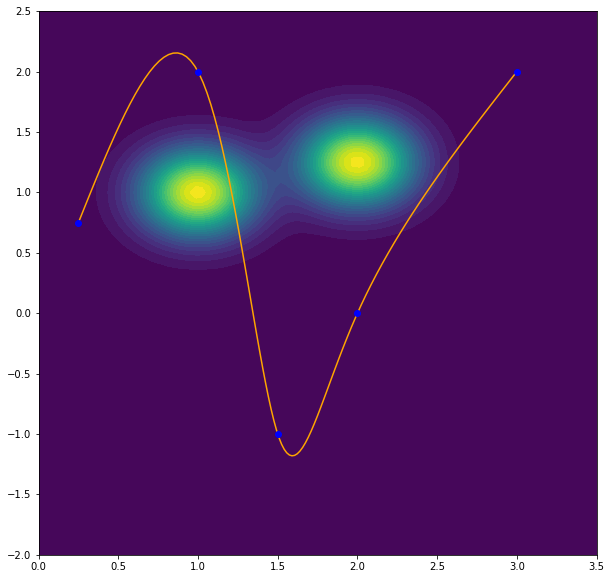

In [36]:
# Simple 2D case
length, channels = 5, 2
start_pose = torch.tensor([0.25, 0.75])
target_pose = torch.tensor([3.0, 2.0])
sample_knots = torch.tensor([[1., 2.0], [1.5, -1.0], [2.0, 0.0]])
knots  = torch.cat((start_pose.unsqueeze(0), sample_knots, target_pose.unsqueeze(0)), 0)


# Plot an initial spline
traj = create_spline_trajectory(knots)

plot_2d(log_p)
plt.plot(traj[:, 0], traj[:, 1], color='orange')
plt.plot(knots[:, 0], knots[:, 1], 'ob')
plt.show()

In [4]:
# Sets up the optimization problem
x = torch.tensor([[1., 2.0], [1.5, -1.0], [2.0, 0.0]]).requires_grad_(True)

optimizer = torch.optim.Adam(params=[x], lr=.1)
n_iter = 500

def step(x):
    optimizer.zero_grad()
    cost = cost_function(log_p, x, start_pose, target_pose)
    d_cost = -torch.autograd.grad(cost, x, create_graph=True)[0]
    x.grad = -d_cost
    optimizer.step()
    
for i in range(n_iter):
    step(x)
    
x = x.detach()

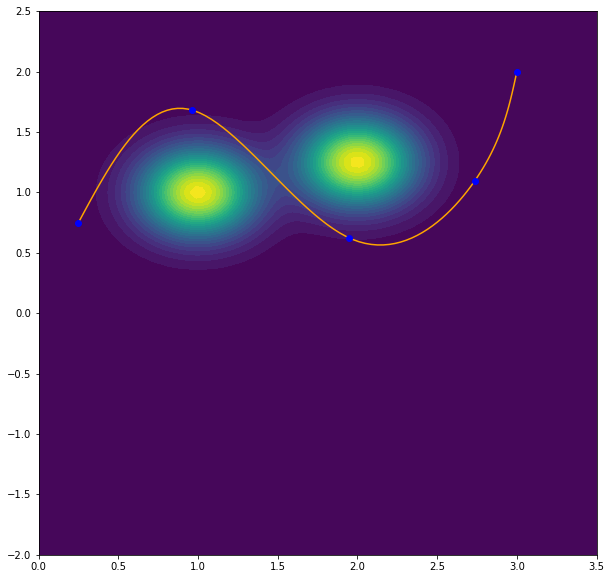

In [5]:
# Plots the solution
knots = torch.cat((start_pose.unsqueeze(0), x, target_pose.unsqueeze(0)), 0)
traj = create_spline_trajectory(knots)

plot_2d(log_p)
plt.plot(traj[:, 0], traj[:, 1], color='orange')
plt.plot(knots[:, 0], knots[:, 1], 'ob')
plt.show()

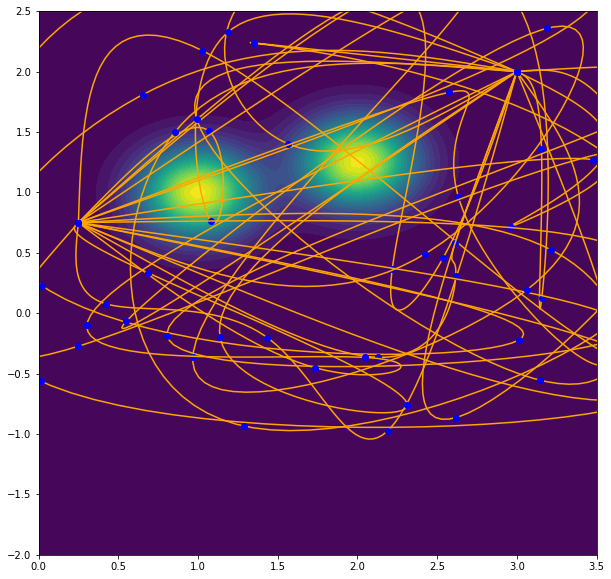

In [47]:
# Batch Spline Optimisation
# This example illustrates batch splines optimisation given a cost function

torch.manual_seed(42)

# Samples points for multiple splines with the same start and target positions
batch, length, channels = 20, 5, 2
start_pose = torch.tensor([0.25, 0.75])
target_pose = torch.tensor([3.0, 2.0])
offset = torch.tensor([0., -1.])
x = 4 * torch.rand(batch, length - 2, channels) + offset 

knots = torch.cat((start_pose.repeat(batch, 1, 1), x, target_pose.repeat(batch, 1, 1)), 1)

# Creates the splines
traj = create_spline_trajectory(knots)

# Plots the splines
plot_2d(log_p)
for i in range(batch):
    plt.plot(traj[i, :, 0], traj[i, :, 1], color='orange')
    plt.plot(knots[i, :, 0], knots[i, :, 1], 'ob')
plt.show()

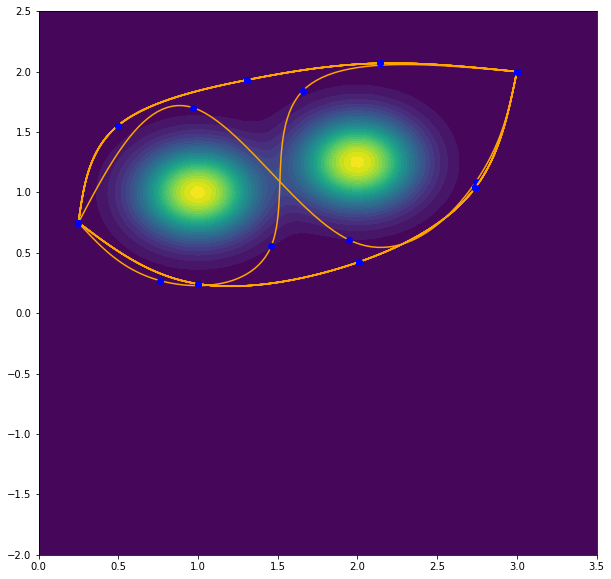

In [57]:
# Batch optimization using Gradient Descent
x = knots[:, 1:-1, :].clone().requires_grad_(True)

optimizer = torch.optim.Adam(params=[x], lr=.01)
n_iter = 1000

def step(x):
    optimizer.zero_grad()
    cost, _ = batch_cost_function(log_p, x, start_pose, target_pose, w=50)
    d_cost = -torch.autograd.grad(cost.sum(), x, create_graph=True)[0]
    x.grad = -d_cost
    optimizer.step()
    
for i in range(n_iter):
    step(x)
x = x.detach()

# Plots the optimized splines
data = torch.cat((start_pose.repeat(batch, 1, 1), x, target_pose.repeat(batch, 1, 1)), 1)
out = create_spline_trajectory(data)

# Plots the splines
plot_2d(log_p)
for i in range(batch):
    plt.plot(out[i, :, 0], out[i, :, 1], color='orange')
    plt.plot(data[i, :, 0], data[i, :, 1], 'ob')
plt.show()

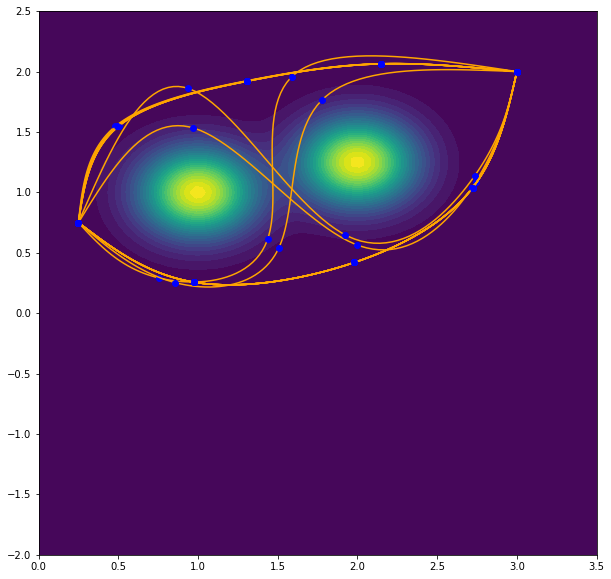

In [56]:
# Batch optimization using SVGD
x = knots[:, 1:-1, :].clone().requires_grad_(True)

n_iter = 1000
kernel = GaussianKernel()
stein_sampler = SVGD(kernel, optimizer_class=torch.optim.Adam, lr=0.01)

# need score estimator to include trajectory length regularization cost
def score_estimator(x):
    cost, _ = batch_cost_function(log_p, x, start_pose, target_pose, w=50)
    # considering the likelihood is exp(-cost)
    grad_log_p = torch.autograd.grad(-cost.sum(), x, retain_graph=True)[0]
    # score_dict = {"k_xx": torch.eye(batch), "grad_k": torch.zeros_like(grad_log_p)}
    score_dict = {}
    return grad_log_p, score_dict  
                    
stein_sampler.optimize(x, score_estimator, n_steps=n_iter)
x = x.detach()

# Plots the optimized splines
data = torch.cat((start_pose.repeat(batch, 1, 1), x, target_pose.repeat(batch, 1, 1)), 1)
out = create_spline_trajectory(data)

# Plots the splines
plot_2d(log_p)
for i in range(batch):
    plt.plot(out[i, :, 0], out[i, :, 1], color='orange')
    plt.plot(data[i, :, 0], data[i, :, 1], 'ob')
plt.show()

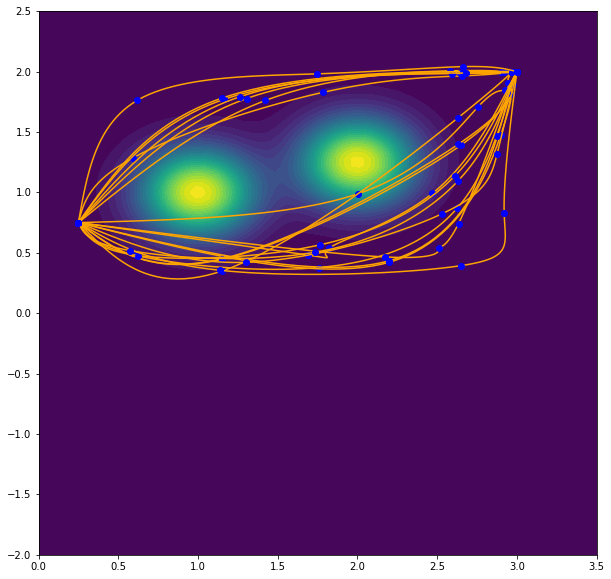

In [13]:
# Batch optimization using SVGD and Trajectory Kernel
x = knots[:, 1:-1, :].clone().requires_grad_(True)

n_iter = 1000
kernel = TrajectoryKernel()
stein_sampler = SVGD(kernel, optimizer_class=torch.optim.Adam, lr=0.01)

# need score estimator to include trajectory length regularization cost
def score_estimator(x):
    cost, traj = batch_cost_function(log_p, x, start_pose, target_pose)
    # considering the likelihood is exp(-cost)
    grad_log_p = -torch.autograd.grad(-cost.sum(), x, retain_graph=True)[0].flatten(1)
    k_xx, grad_k = 0, 0
    for i in range(x.shape[-1]):
        k_xx_i, grad_k_i = kernel(traj[..., i], traj[..., i], x)
        k_xx += k_xx_i
        grad_k += grad_k_i.flatten(1)
    score_dict = {"k_xx": k_xx, "grad_k": grad_k}
    return grad_log_p, score_dict  
                    
stein_sampler.optimize(x, score_estimator, n_steps=n_iter)
x = x.detach()
    
# Plots the optimized splines
data = torch.cat((start_pose.repeat(batch, 1, 1), x, target_pose.repeat(batch, 1, 1)), 1)
out = create_spline_trajectory(data)

# Plots the splines
plot_2d(log_p)
for i in range(batch):
    plt.plot(out[i, :, 0], out[i, :, 1], color='orange')
    plt.plot(data[i, :, 0], data[i, :, 1], 'ob')
plt.show()

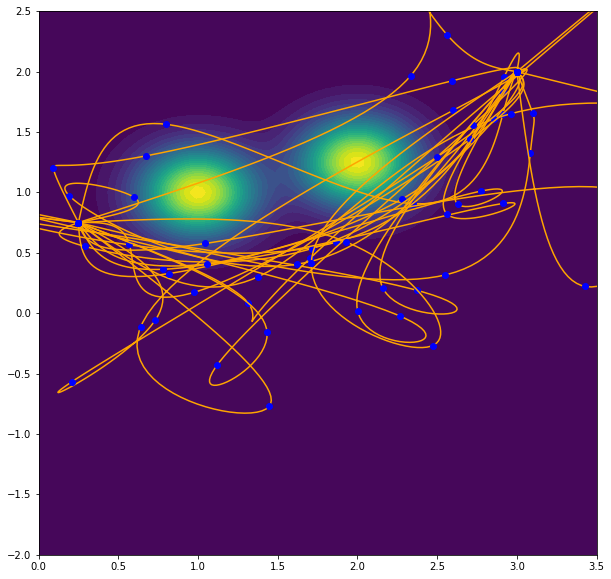

In [19]:
# Batch optimization using SVGD and Path Signature Kernel
x = knots[:, 1:-1, :].clone().requires_grad_(True)

n_iter = 1000
kernel = PathSigKernel()
stein_sampler = SVGD(kernel, optimizer_class=torch.optim.Adam, lr=0.01)

# need score estimator to include trajectory length regularization cost
def score_estimator(x):
    cost, traj = batch_cost_function(log_p, x, start_pose, target_pose)
    # considering the likelihood is exp(-cost)
    grad_log_p = torch.autograd.grad(-cost.sum(), x, retain_graph=True)[0].flatten(1)
    k_xx, grad_k = kernel(traj, traj, x, depth=5)
    score_dict = {"k_xx": k_xx.detach(), "grad_k": grad_k.detach()}
    return grad_log_p, score_dict  
                    
stein_sampler.optimize(x, score_estimator, n_steps=n_iter)
x = x.detach()
    
# Plots the optimized splines
data = torch.cat((start_pose.repeat(batch, 1, 1), x, target_pose.repeat(batch, 1, 1)), 1)
out = create_spline_trajectory(data)

# Plots the splines
plot_2d(log_p)
for i in range(batch):
    plt.plot(out[i, :, 0], out[i, :, 1], color='orange')
    plt.plot(data[i, :, 0], data[i, :, 1], 'ob')
plt.show()